# This is an example to download and extract HYDAT dataset (discharge information for Canadian hydrometric stations) and save it per station, or per groupe in a csv or netcdf format

In [1]:
import requests
from   bs4 import BeautifulSoup
import os
import glob
from   zipfile import ZipFile
#from easymore import easymore # for version 1 and below
from easymore import Easymore # for version 2 and above
import pandas as pd
import sqlite3
import datetime
import xarray as xr

In [5]:
def HYDAT_download(url, folder_to_save): # downlaod and unzip

    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")

    links = []
    for link in soup.find_all("a"):
        href = link.get("href")
        if href and href.startswith("Hydat_sqlite3") and href.endswith(".zip"):
            links.append(href)

    if len(links) == 1:
        HYDAT_link = url+links[0]
    else:
        print('There are multiple files in links')

    if not os.path.isdir(folder_to_save):
        os.makedirs(folder_to_save)

    r = requests.get(HYDAT_link) # download the URL
    # print the specification of the download 
    print(r.status_code, r.headers['content-type'], r.encoding)
    # if download successful the statuse code is 200 then save the file, else print what was not downloaded
    if r.status_code == 200:
        print('download was successful for '+url)
        with open(folder_to_save+ 'HYDAT.zip', 'wb') as f:
            f.write(r.content)
    else:
        print('download was not successful for '+url)
    
    # unzip the folder
    name_zips = glob.glob(folder_to_save+ 'HYDAT.zip')  # getting the name of the all the downloaded zip file in one directory
    # loop over the zip file names and unzip them
    for name_zip in name_zips:
        with ZipFile(name_zip, 'r') as zipObj:
            # Extract all the contents of zip file in different directory
            folder_name = name_zip[:-4] # removing the zip extension (.zip)
            zipObj.extractall(folder_to_save)

def get_the_daily_dataframe(
    df: pd.DataFrame,
    regex_str: str,
    col: str,
    *args,
    **kwargs,
) -> pd.DataFrame:
    
    # filter and trim columns
    df = df.filter(regex=regex_str, axis=1) # extract the columns
    df.columns = df.columns.str.replace(r'\D', '', regex=True) # remove non-digits
    df = df.stack(dropna=False) # stack without dropping
    df.index.names = ['STATION_NUMBER', 'YEAR', 'MONTH', 'DAY'] # assign index names
    df = df.reset_index() # reset index to add another level
    df['DATE'] = pd.to_datetime(df[['YEAR', 'MONTH', 'DAY']].astype(str).agg('-'.join, axis=1),\
                                errors='coerce') # define date column
    df.drop(columns=['YEAR', 'MONTH', 'DAY'], inplace=True) # drop unnecessary columns
    df.dropna(subset=['DATE'], inplace=True) # remove invalid dates
    df.set_index(keys=['STATION_NUMBER', 'DATE'], drop=True, inplace=True) # set index levels
    df.columns = [col] # assing column name
    
    # pivot data to look nice
    df = df.unstack(level='STATION_NUMBER')
    df = df.reorder_levels(order=[1,0], axis=1)
    
    return df


def extract_station_daily_flow(
    station: str,
    connection: str, # sqlite3 file location
    start_date: str = '1850-01-01',
    end_date: str = str(datetime.datetime.now().date()),
    *args,
    **kwargs,
) -> pd.DataFrame:
    
    '''
    This function simply extracts data from the HYDAT sqlite3 database
    '''
    
    connection = sqlite3.connect(connection)
    
    # read station data
    df = pd.read_sql_query(f"SELECT * FROM DLY_FLOWS WHERE STATION_NUMBER LIKE '%{station}%'", connection)
    
    # set index
    df.set_index(keys=['STATION_NUMBER', 'YEAR', 'MONTH'], drop=True, inplace=True)
    
    # get the FLOW and FLAG
    df_flow = get_the_daily_dataframe(df, r'^FLOW\d', 'FLOW')
    df_flag = get_the_daily_dataframe(df, r'^FLOW_.', 'FLAG')
    
    #
    df_flow.sort_index(axis=0, inplace=True)
    df_flow.sort_index(axis=1, level=0, ascending=False, inplace=True)
    df_flow.columns = df_flow.columns.droplevel(1)
    df_flow.columns.name = None
    
    df_flag.sort_index(axis=0, inplace=True)
    df_flag.sort_index(axis=1, level=0, ascending=False, inplace=True)
    df_flag.columns = df_flag.columns.droplevel(1)
    df_flag.columns.name = None
    
    df_flow = df_flow.loc[start_date:end_date, :]
    df_flag = df_flag.loc[start_date:end_date, :]
    
    # stations information
    df_info = pd.read_sql_query(f"SELECT * FROM STATIONS WHERE STATION_NUMBER LIKE '%{station}%'", connection)
    
    return df_flow, df_flag, df_info

def get_all_stations_with_daily_flow(
    connection: str, # sqlite3 file location
    )-> list:
    
    connection = sqlite3.connect(connection)
    
    # Create a cursor object
    cursor = connection.cursor()

    # Construct the SQL statement to retrieve the unique STATION_NUMBER values
    table_name = 'DLY_FLOWS'
    column_name = 'STATION_NUMBER'
    sql = "SELECT DISTINCT {} FROM {}".format(column_name, table_name)

    # Execute the SQL statement
    cursor.execute(sql)

    # Fetch the results
    results = cursor.fetchall() 
    results = [str(x).replace('(', '').replace(')', '').replace(',', '') for x in results]
    results = [x.replace("'", "") for x in results]
    
    return results

def get_all_stations_with_daily_flow_info(
    connection: str, # sqlite3 file location
    )-> pd.DataFrame:
    
    connection = sqlite3.connect(connection)
    station = ''
    # stations information
    df_info = pd.read_sql_query(f"SELECT * FROM STATIONS WHERE STATION_NUMBER LIKE '%{station}%'", connection)
    
    return df_info
    

def create_csv_nc(HYDAT_sqlite_location,
                  folder_to_save,
                  station,
                  save_nc = False,
                  start_date: str = '1850-01-01',
                  end_date: str = str(datetime.datetime.now().date()),):
    
    if not os.path.isdir(folder_to_save):
        os.makedirs(folder_to_save)

    df_flow, df_flag, df_info = extract_station_daily_flow(station,
                                                           HYDAT_sqlite_location,
                                                           start_date=start_date,
                                                           end_date=end_date)
    # save the csv
    df_flow.to_csv(folder_to_save+station+'_Flow.csv')
    df_flag.to_csv(folder_to_save+station+'_Flag.csv')
    df_info.to_csv(folder_to_save+station+'_Info.csv')
    # save to netcdf using easymore
    if save_nc:
        esmr = Easymore() # easymore version 2 and above
        # esmr = easymore() # easymore version 1 and below
        ds_flow = esmr.dataframe_to_netcdf_xr(df_flow,
                                              variable_name = 'Flow',
                                              unit_of_variable = 'm**3 s**-1',
                                              variable_long_name = 'daily discharge from HYDAT dataset',
                                              Fill_value = '-9999',
                                              station_info_data = df_info,
                                              station_info_column = 'STATION_NUMBER')
                                              #  nc_file_name = station+'_Flow.nc',
                                              #  nc_file_path = folder_to_save,
        ds_flag = esmr.dataframe_to_netcdf_xr(df_flag,
                                              variable_name = 'Flag',
                                              unit_of_variable = '-',
                                              variable_long_name = 'flag for daily discharge from HYDAT dataset',
                                              Fill_value = '-9999',
                                              station_info_data = df_info,
                                              station_info_column = 'STATION_NUMBER')
                                              #  nc_file_name = station+'_Flag.nc',
                                              #  nc_file_path = folder_to_save,
        ds = xr.merge([ds_flow,ds_flag])
        if os.path.isfile(folder_to_save+station+'.nc'):
            os.remove(folder_to_save+station+'.nc')
        ds.to_netcdf(folder_to_save+station+'.nc')
        


## Download HYDAT dataset

In [3]:
# inputs
url = "https://collaboration.cmc.ec.gc.ca/cmc/hydrometrics/www/" # url may not change but better to check
folder_to_save = './temporary/HYDAT/' # place where the files are saved

# download the HYDAT data if already not donwloaded
HYDAT_download(url, folder_to_save)

200 application/zip None
download was successful for https://collaboration.cmc.ec.gc.ca/cmc/hydrometrics/www/


## get slice of HYDAT dataset for station with a substring and visualize

EASYMORE version 2.0.0 is initiated.
EASYMORE detects that the input datafarame is pandas dataframe
EASYMORE detects that index is pandas datatime
EASYMORE detects that the station data is pandas dataframe
EASYMORE detects that the necessary information for the station are provided with transpose
EASYMORE detects that the input datafarame is pandas dataframe
EASYMORE detects that index is pandas datatime
EASYMORE detects that the station data is pandas dataframe
EASYMORE detects that the necessary information for the station are provided with transpose
Frozen({'Flow': <xarray.Variable (time: 41397)>
[41397 values with dtype=float64]
Attributes:
    units:      m**3 s**-1
    long_name:  daily discharge from HYDAT dataset, 'time': <xarray.IndexVariable 'time' (time: 41397)>
array(['1909-05-01T00:00:00.000000000', '1909-05-02T00:00:00.000000000',
       '1909-05-03T00:00:00.000000000', ..., '2022-12-29T00:00:00.000000000',
       '2022-12-30T00:00:00.000000000', '2022-12-31T00:00:00.0000

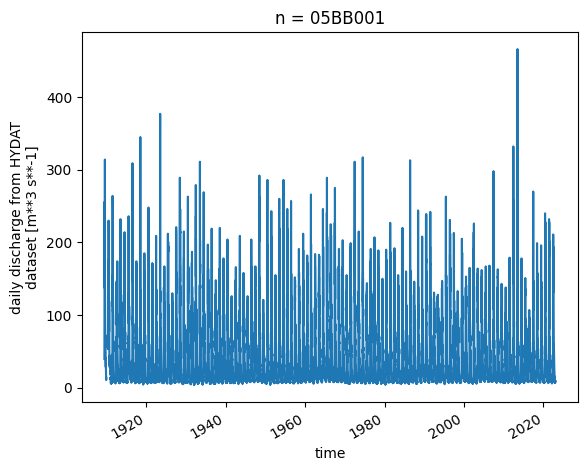

In [6]:
# get all the station ID with substring 05BB
create_csv_nc(folder_to_save+'Hydat.sqlite3', folder_to_save, '05BB', save_nc = True)
#
ds = xr.open_dataset(folder_to_save+'05BB.nc')
ds_slice = ds.sel(n='05BB001')
print(ds_slice.variables)
ds_slice.Flow.plot()

## get the infromation for all the stations

In [7]:
station_info = get_all_stations_with_daily_flow_info(folder_to_save+'Hydat.sqlite3')
station_info

,STATION_NUMBER,STATION_NAME,PROV_TERR_STATE_LOC,REGIONAL_OFFICE_ID,HYD_STATUS,SED_STATUS,LATITUDE,LONGITUDE,DRAINAGE_AREA_GROSS,DRAINAGE_AREA_EFFECT,RHBN,REAL_TIME,CONTRIBUTOR_ID,OPERATOR_ID,DATUM_ID
0,01AA002,DAAQUAM (RIVIERE) EN AVAL DE LA RIVIERE SHIDGEL,QC,6,D,None,46.557499,-70.081108,598.000000,NaN,0,0,740.0,740.0,405.0
1,01AD001,MADAWASKA (RIVIERE) A 6 KM EN AVAL DU BARRAGE ...,QC,6,D,None,47.548328,-68.636391,2690.000000,NaN,0,0,647.0,740.0,405.0
2,01AD002,SAINT JOHN RIVER AT FORT KENT,ME,7,A,None,47.258060,-68.595833,14700.000000,NaN,1,0,647.0,600.0,42.0
3,01AD003,ST. FRANCIS RIVER AT OUTLET OF GLASIER LAKE,NB,7,A,None,47.206612,-68.956940,1350.000000,NaN,1,1,647.0,647.0,10.0
4,01AD004,SAINT JOHN RIVER AT EDMUNDSTON,NB,7,A,None,47.360779,-68.324890,15500.000000,NaN,0,1,647.0,647.0,35.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7958,11AE018,POPLAR RIVER ABOVE BOLSTER CREEK,SK,8,D,None,49.103329,-106.019997,308.000000,NaN,0,0,323.0,323.0,NaN
7959,11AF001,WILLOW BUNCH LAKE NEAR VICEROY,SK,8,D,None,49.433331,-105.400002,NaN,578.000000,0,0,NaN,NaN,10.0
7960,11AF002,BIG MUDDY CREEK AT INTERNATIONAL BOUNDARY,SK,8,D,None,49.008331,-104.861107,88.599998,85.199997,0,0,NaN,NaN,NaN
7961,11AF004,BEAVER CREEK NEAR INTERNATIONAL BOUNDARY,MT,8,D,None,48.988892,-105.011108,458.000000,448.000000,0,0,NaN,NaN,NaN


In [8]:
# loop over all the station with flow variable
all_station_with_Flow = get_all_stations_with_daily_flow (folder_to_save+'Hydat.sqlite3')
all_station_with_Flow = all_station_with_Flow[0:4] # just the first four, this can be commneted if all stations are needed
for station in all_station_with_Flow:
    create_csv_nc(folder_to_save+'Hydat.sqlite3', folder_to_save, station, save_nc = True)
    

EASYMORE version 2.0.0 is initiated.
EASYMORE detects that the input datafarame is pandas dataframe
EASYMORE detects that index is pandas datatime
EASYMORE detects that the station data is pandas dataframe
EASYMORE detects that the necessary information for the station are provided with transpose
EASYMORE detects that the input datafarame is pandas dataframe
EASYMORE detects that index is pandas datatime
EASYMORE detects that the station data is pandas dataframe
EASYMORE detects that the necessary information for the station are provided with transpose
EASYMORE version 2.0.0 is initiated.
EASYMORE detects that the input datafarame is pandas dataframe
EASYMORE detects that index is pandas datatime
EASYMORE detects that the station data is pandas dataframe
EASYMORE detects that the necessary information for the station are provided with transpose
EASYMORE detects that the input datafarame is pandas dataframe
EASYMORE detects that index is pandas datatime
EASYMORE detects that the station